In [308]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, layers
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

In [309]:
# Path to ./data/processed folder
path_data_processed = os.path.join(
    os.path.abspath('../'),
    'data',
    'processed'
)

# Load Data

In [310]:
df_stocks = pd.read_csv(
    os.path.join(
        path_data_processed,
        'stock_market_dataset.csv'
    ),
    index_col=0
)

df_stocks = df_stocks.pivot_table(
    values='Close',
    index='Date',
    columns='Stock'
).reset_index(drop=False)

In [311]:
df_agg = pd.read_csv(
    os.path.join(
        path_data_processed,
        'reddit_news_avg_score_per_label.csv'
    )
)

In [312]:
df = df_stocks.merge(df_agg, on='Date', how='left')

stocks = ['AAPL'] # , 'AMZN', 'GOOGL', 'MSFT', 'NVDA'
for stock in stocks:
    df[f'{stock}_target'] = df[stock].shift(1)

In [313]:
# df = df_stocks[['Date', 'AAPL']]
# df['AAPL_target'] = df['AAPL'].shift(1)

In [314]:
df

,Date,AAPL,AMZN,GOOGL,MSFT,NVDA,negative,neutral,positive,AAPL_target
0,2008-06-09,23.257,79.43,278.94,23.238,21.978,0.800000,0.995000,NaN,NaN
1,2008-06-10,23.774,79.62,277.08,23.389,20.680,0.915000,0.983684,NaN,23.257
2,2008-06-11,23.156,77.28,272.60,22.744,19.714,0.915000,0.941905,1.000000,23.774
3,2008-06-12,22.189,76.15,276.48,23.682,19.837,0.816667,0.929000,0.930000,23.156
4,2008-06-13,22.074,79.17,285.76,24.377,19.771,0.985000,0.990000,0.500000,22.189
...,...,...,...,...,...,...,...,...,...,...
2027,2016-06-27,89.635,691.36,681.14,46.998,44.945,0.880000,0.972143,0.892500,90.960
2028,2016-06-28,91.145,707.95,691.26,47.978,45.592,0.980000,0.971765,0.810000,89.635
2029,2016-06-29,91.934,715.46,695.19,49.045,46.315,0.937500,0.959412,0.990000,91.145
2030,2016-06-30,93.102,715.62,703.53,49.657,46.705,0.940000,0.976667,0.986667,91.934


# Data Preparation

In [315]:
# Select features
data = df.drop([
    'Date',
    'AMZN', 'GOOGL', 'MSFT', 'NVDA'
    ], axis=1)

data['positive'] = data['positive'].fillna(0)
data['negative'] = data['negative'].fillna(0)

data = data.dropna()

In [316]:
data

,AAPL,negative,neutral,positive,AAPL_target
1,23.774,0.915000,0.983684,0.000000,23.257
2,23.156,0.915000,0.941905,1.000000,23.774
3,22.189,0.816667,0.929000,0.930000,23.156
4,22.074,0.985000,0.990000,0.500000,22.189
5,22.647,0.956667,0.984286,1.000000,22.074
...,...,...,...,...,...
2027,89.635,0.880000,0.972143,0.892500,90.960
2028,91.145,0.980000,0.971765,0.810000,89.635
2029,91.934,0.937500,0.959412,0.990000,91.145
2030,93.102,0.940000,0.976667,0.986667,91.934


## Train-Test Split

In [317]:
# Set train percentage
train_percentage = 0.95

# Compute lenght of train dataframe
train_len = int(len(data) * train_percentage)

In [318]:
# Create data_train and data_test:
df_train = data.iloc[:train_len]
df_test = data.iloc[train_len:]

In [319]:
data.columns

Index(['AAPL', 'negative', 'neutral', 'positive', 'AAPL_target'], dtype='object')

In [320]:
data.head()

,AAPL,negative,neutral,positive,AAPL_target
1,23.774,0.915000,0.983684,0.00,23.257
2,23.156,0.915000,0.941905,1.00,23.774
3,22.189,0.816667,0.929000,0.93,23.156
4,22.074,0.985000,0.990000,0.50,22.189
5,22.647,0.956667,0.984286,1.00,22.074


<Axes: xlabel='AAPL_target'>

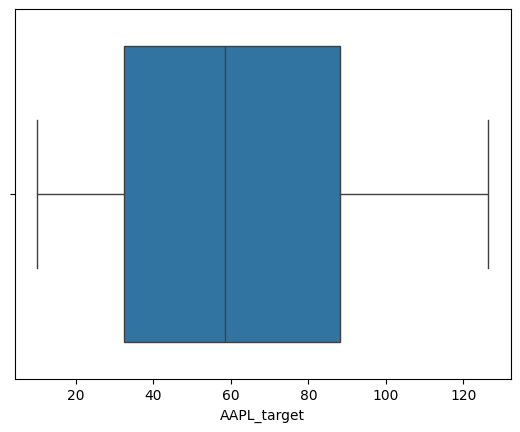

In [321]:
sns.boxplot(data=data, x='AAPL_target')

## Scaling
Transforming numerical features into a common smaller range

In [322]:
features_scale = [
    'AAPL',
    # 'AMZN',
    # 'GOOGL',
    # 'MSFT',
    # 'NVDA',
    # 'negative',
    # 'neutral',
    # 'positive'
]

target = [
    'AAPL_target',
    # 'AMZN_target',
    # 'GOOGL_target',
    # 'MSFT_target',
    # 'NVDA_target'
]

target_scaler = MinMaxScaler().fit(df_train[target])
df_train[target] = target_scaler.transform(df_train[target])
df_test[target] = target_scaler.transform(df_test[target])

features_scaler = MinMaxScaler().fit(df_train[features_scale])
df_train[features_scale] = features_scaler.transform(df_train[features_scale])
df_test[features_scale] = features_scaler.transform(df_test[features_scale])

/tmp/ipykernel_2047/1299088375.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[target] = target_scaler.transform(df_train[target])
/tmp/ipykernel_2047/1299088375.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[target] = target_scaler.transform(df_test[target])
/tmp/ipykernel_2047/1299088375.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

## Subsequences

In [323]:
# Create subsequence with 5 business days X 4 weeks X 3 months
length = 5 * 4 * 3
horizon = 1
window = 1

### One Subsequence

In [324]:
def subsequence(df, length, features, target):
    X, y = [], []

    for i in range(length, df.shape[0]):
        X.append(df[features].iloc[i - length: i]) #  + target
        y.append(df[target].iloc[i])

    X = np.array(X)
    y = np.expand_dims(
        np.array(y).astype(np.float32),
        axis=-1
    )

    return X, y

In [325]:
features = [
    'AAPL',
    # 'AMZN',
    # 'GOOGL',
    # 'MSFT',
    # 'NVDA',
    'negative',
    'neutral',
    'positive'
]

X_train, y_train = subsequence(df_train, length, features, target)

X_test, y_test = subsequence(df_test, length, features, target)

In [326]:
y_train.shape

(1869, 1, 1)

In [327]:
X_train.shape

(1869, 60, 4)

In [ ]:
alpha = 0.1

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ('lasso', Lasso(alpha=alpha))
    ]
)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# RNN Model

In [329]:
# Padding train and test
X_train_pad = pad_sequences(X_train, value=-999, padding='post', dtype='float64')
X_test_pad = pad_sequences(X_test, value=-999, padding='post', dtype='float64')

In [330]:
# Build the model
def rnn_model():
    model = Sequential()

    model.add(layers.Masking(mask_value=-999))

    model.add(
        layers.LSTM(
            units=128,
            return_sequences = True,
            activation = "tanh",
            input_shape = X_train_pad[0].shape
        )
    )

    model.add(
        layers.LSTM(
            units=64,
            return_sequences = False,
            activation = "tanh"
        )
    )

    model.add(layers.Dense(25, activation="relu"))

    model.add(layers.Dense(1, activation="relu"))

    my_mae = metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None)

    model.compile(
        loss="mse",
        optimizer = "rmsprop",
        metrics = [my_mae]
    )

    return model

model = rnn_model()

/home/nathalia/.pyenv/versions/3.10.6/envs/stocks_vs_behavior/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [331]:
%%time

es = EarlyStopping(patience = 25, monitor = "val_mean_absolute_error")

history = model.fit(
    X_train_pad,
    np.array(y_train),
    validation_split = 0.3,
    batch_size=16,
    epochs=300,
    verbose = 1,
    callbacks = [es]
)

Epoch 1/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - loss: 0.0206 - mean_absolute_error: 0.1071 - val_loss: 0.0065 - val_mean_absolute_error: 0.0670
Epoch 2/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 0.0040 - mean_absolute_error: 0.0510 - val_loss: 0.0045 - val_mean_absolute_error: 0.0552
Epoch 3/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 0.0023 - mean_absolute_error: 0.0407 - val_loss: 0.0064 - val_mean_absolute_error: 0.0646
Epoch 4/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 0.0018 - mean_absolute_error: 0.0335 - val_loss: 0.0095 - val_mean_absolute_error: 0.0837
Epoch 5/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 0.0016 - mean_absolute_error: 0.0311 - val_loss: 0.0120 - val_mean_absolute_error: 0.1000
Epoch 6/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 0.0011 - mean_absolute_error: 0.0263 - val_loss: 0.0033 - val_mean_absolute_error: 0.0456
Epoch 7/300
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - loss: 0.0011 - mean_absolute_err

In [332]:
for i in history.history.keys():
    value = np.mean(history.history[i])
    print(i, " = ", value)

loss  =  0.0003437233238232121
mean_absolute_error  =  0.01221379114894899
val_loss  =  0.0013129407004766936
val_mean_absolute_error  =  0.026506388493016095


In [333]:
from sklearn.metrics import r2_score

In [334]:
def plot_loss_mae(history):

    fig, ax =plt.subplots(1,2,figsize=(20,5))

    # --- LOSS

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- MAE

    ax[1].plot(history.history['mean_absolute_error'])
    ax[1].plot(history.history['val_mean_absolute_error'])
    ax[1].set_title('Model MAE', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    plt.show()

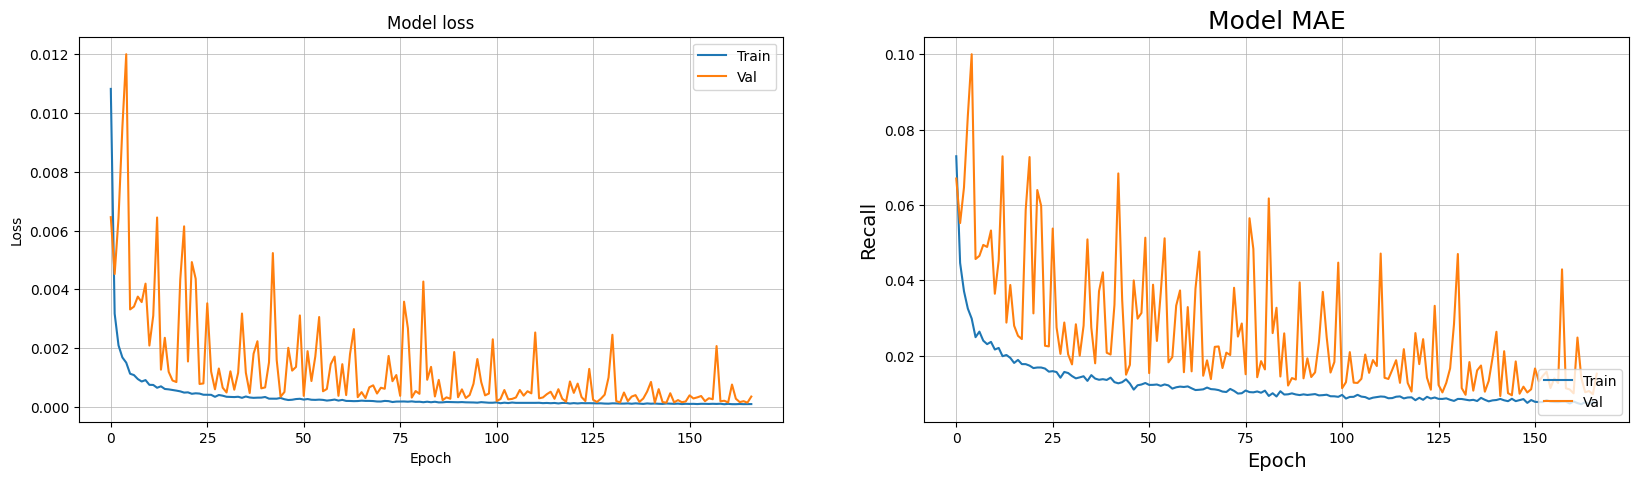

In [335]:
plot_loss_mae(history)

In [336]:
X_train_pad.shape

(1869, 60, 4)

In [337]:
np.array(y_train).shape

(1869, 1, 1)

In [338]:
y_pred = target_scaler.inverse_transform(model.predict(X_test))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step


In [339]:
y_test2 = y_test[:, 0, 0]

In [340]:
y_pred.shape

(42, 1)

In [341]:
y_test2

array([0.7050208 , 0.6967959 , 0.6936193 , 0.68925786, 0.68985885,
       0.69512177, 0.687515  , 0.66936535, 0.6708678 , 0.69896805,
       0.69570553, 0.7046602 , 0.7016295 , 0.71017206, 0.72027713,
       0.7325801 , 0.7467976 , 0.75357157, 0.7530736 , 0.74896973,
       0.73725057, 0.7310777 , 0.7327432 , 0.73869294, 0.7420241 ,
       0.7412686 , 0.7472097 , 0.74044436, 0.72789246, 0.7289055 ,
       0.72622687, 0.7296439 , 0.7110907 , 0.7091761 , 0.7159415 ,
       0.7130138 , 0.7175298 , 0.6949586 , 0.6835829 , 0.6965469 ,
       0.70332086, 0.7133487 ], dtype=float32)

In [342]:
X_train_pad.shape

(1869, 60, 4)

In [343]:
y_train.shape

(1869, 1, 1)

In [344]:
r2 = r2_score(np.expand_dims(y_test2, -1), model.predict(X_test))
r2

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


0.676230788230896

In [345]:
len(y_pred)

42

In [346]:
tmp = df_test.copy()
tmp['target'] = target_scaler.inverse_transform(tmp[['AAPL_target']])

In [347]:
X_test.shape

(42, 60, 4)

In [348]:
y_pred

array([[89.005806],
       [89.204445],
       [89.232086],
       [89.301186],
       [89.20933 ],
       [89.54232 ],
       [89.39717 ],
       [88.56815 ],
       [87.794106],
       [88.52321 ],
       [89.449265],
       [90.41488 ],
       [91.18081 ],
       [91.57805 ],
       [92.195366],
       [93.11712 ],
       [94.58135 ],
       [95.78076 ],
       [96.85754 ],
       [96.79316 ],
       [96.028145],
       [94.98951 ],
       [94.20196 ],
       [94.60656 ],
       [94.67191 ],
       [94.95039 ],
       [95.32337 ],
       [95.26603 ],
       [94.97143 ],
       [94.23183 ],
       [93.65505 ],
       [93.37711 ],
       [92.582756],
       [91.82176 ],
       [91.849396],
       [91.808945],
       [92.00285 ],
       [91.08863 ],
       [89.76974 ],
       [89.490036],
       [89.81823 ],
       [90.64735 ]], dtype=float32)

In [349]:
y_real - y_pred

array([[ 3.12619403],
       [ 1.96955511],
       [ 1.57191382],
       [ 0.99481439],
       [ 1.1566723 ],
       [ 1.43667975],
       [ 0.69582898],
       [-0.58915338],
       [ 0.35989447],
       [ 2.90379138],
       [ 1.59773547],
       [ 1.67512115],
       [ 0.55619098],
       [ 1.15395129],
       [ 1.71363409],
       [ 2.22488116],
       [ 2.41664777],
       [ 2.00623828],
       [ 0.87146368],
       [ 0.45784052],
       [-0.14214484],
       [ 0.17749042],
       [ 1.1590423 ],
       [ 1.44744025],
       [ 1.77008685],
       [ 1.40360632],
       [ 1.72262811],
       [ 0.99197064],
       [-0.17542792],
       [ 0.68217322],
       [ 0.94694781],
       [ 1.62288666],
       [ 0.25624396],
       [ 0.79423792],
       [ 1.55460425],
       [ 1.2540553 ],
       [ 1.58614661],
       [-0.12863068],
       [-0.13473724],
       [ 1.65496399],
       [ 2.11577032],
       [ 2.4546535 ]])

In [350]:
df_diff = pd.concat([
    pd.DataFrame(y_real, columns=['Real']),
    pd.DataFrame(y_pred, columns=['Pred'])
], axis=1
)

df_diff['Next_Real'] = df_diff['Real'].shift(-1)
df_diff['Next_Pred'] = df_diff['Pred'].shift(-1)

df_diff['Diff_real'] = df_diff['Real'] - df_diff['Next_Real']
df_diff['Diff_pred'] = df_diff['Pred'] - df_diff['Next_Pred']

In [351]:
df_diff

,Real,Pred,Next_Real,Next_Pred,Diff_real,Diff_pred
0,92.132,89.005806,91.174,89.204445,0.958,-0.198639
1,91.174,89.204445,90.804,89.232086,0.370,-0.027641
2,90.804,89.232086,90.296,89.301186,0.508,-0.069099
3,90.296,89.301186,90.366,89.209328,-0.070,0.091858
4,90.366,89.209328,90.979,89.542320,-0.613,-0.332993
5,90.979,89.542320,90.093,89.397171,0.886,0.145149
6,90.093,89.397171,87.979,88.568153,2.114,0.829018
7,87.979,88.568153,88.154,87.794106,-0.175,0.774048
8,88.154,87.794106,91.427,88.523209,-3.273,-0.729103
9,91.427,88.523209,91.047,89.449265,0.380,-0.926056
